# What Software Engineers Earn Compared to the General Population

In this notebook we'll compare the median annual income of Software Engineers to the average annual income (GDP per Capita) in 50 countries. It's shown how to scrape the data from a web page using [lxml](http://lxml.de/), turn it into a [Pandas](http://pandas.pydata.org/) dataframe, clean it up and create scatter and bar plots with [matplotlib](http://matplotlib.org/) to visualize the general trend and see which countries are the best and worst for Software Engineers based on how much they earn compared to the average person.

The data comes from [PayScale](http://www.payscale.com/) and the [International Monetary Fund](http://www.imf.org/) and was published by [Bloomberg](http://www.bloomberg.com/visual-data/best-and-worst/highest-paid-software-engineers-countries) in May 2014. It includes figures for 50 countries for which data was most available to PayScale. The Software Engineer figures represent income data collected from May 1, 2013, to May 1, 2014, and use exchange rates from May 5, 2014. The median years of work experience for survey respondents from each country range from two to five years.

## Setup

First we load the necessary libraries, set the plot style and some variables, inlcuding a [geonamescache](https://github.com/yaph/geonamescache) object for adding country codes used to link geographic data with income figures in this [interactive map]().

In [263]:
%load_ext signature
%matplotlib inline

import os

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import geonamescache

from lxml import html

mpl.style.use('ramiro')

data_dir = os.path.expanduser('~/data')
gc = geonamescache.GeonamesCache()

chartinfo = '''Figures represent income data from May 2013 to May 2014 using exchange rates from May 2014. Average annual income figures are for 2014.
Author: Ramiro Gómez - ramiro.org • Data: Bloomberg/PayScale - bloomberg.com/visual-data/best-and-worst/highest-paid-software-engineers-countries'''

The signature extension is already loaded. To reload it, use:
  %reload_ext signature


## Data retrieval and cleanup

To scrape the data from the web page, I looked at the source to determine a way to identify the data table. It is the only table on the page with a class of `hid` so the xpath expression below can be used to extract the table from the HTML source after it was loaded.

In [302]:
url ='http://www.bloomberg.com/visual-data/best-and-worst/highest-paid-software-engineers-countries'
xpath = '//table[@class="hid"]'
 
tree = html.parse(url)
table = tree.xpath(xpath)[0]
raw_html = html.tostring(table)

Pandas makes it easy to turn this raw HTML string into a dataframe. We instruct it to use the `Rank` column as the index and the first row as the header. The [read_html](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_html.html) function returns a list, in our case of one dataframe object, so we just grab this and print the first few rows

In [303]:
df = pd.read_html(raw_html, header=0, index_col=0)[0]
df.head()

,Country,Ratio of median software engineer pay to average income,Median annual pay for software engineers,Average annual income
Rank,,,,
1,Pakistan t,5.56,"$7,200","$1,296"
2,India t,3.91,"$6,200","$1,584"
3,South Africa t,3.64,"$24,000","$6,595"
4,Bulgaria t,3.28,"$25,200","$7,682"
5,China t,3.15,"$23,100","$7,333"


and the data types that were automatically determined by Pandas.

In [304]:
df.dtypes

Country                                                     object
Ratio of median software engineer pay to average income    float64
Median annual pay for software engineers                    object
Average annual income                                       object
dtype: object

The output above shows, that we need to do some cleanup before continuing with further exploration. The values in the `Country` column all end in a space followed by a t, which we just remove. Also we need to turn the dollar amounts into a numeric type for use in calculations and plots.

In [305]:
df['Country'] = df['Country'].apply(lambda x: x.rstrip('t').strip())

for col in df.columns[2:]:
    df[col] = pd.to_numeric(df[col].apply(lambda x: x.lstrip('$').replace(',', '')))

df.dtypes

Country                                                     object
Ratio of median software engineer pay to average income    float64
Median annual pay for software engineers                     int64
Average annual income                                        int64
dtype: object

This looks better now. As a sanity check we can test whether the ratio that is contained in the data agrees with the income numbers. To do so we calculate the ratio ourselves and compare it to the existing one.

In [310]:
ratio = round(df['Median annual pay for software engineers'] / df['Average annual income'], 2)
all(ratio == df['Ratio of median software engineer pay to average income'])

True

## Exploration and visualization

To get a holistic view we first create a scatter plot with all 50 records showing the median Software Engineer income on the X axis and the annual average of the whole population on the Y axis. We also draw a quadratic polynomial fitting curve to see if we can spot a trend.

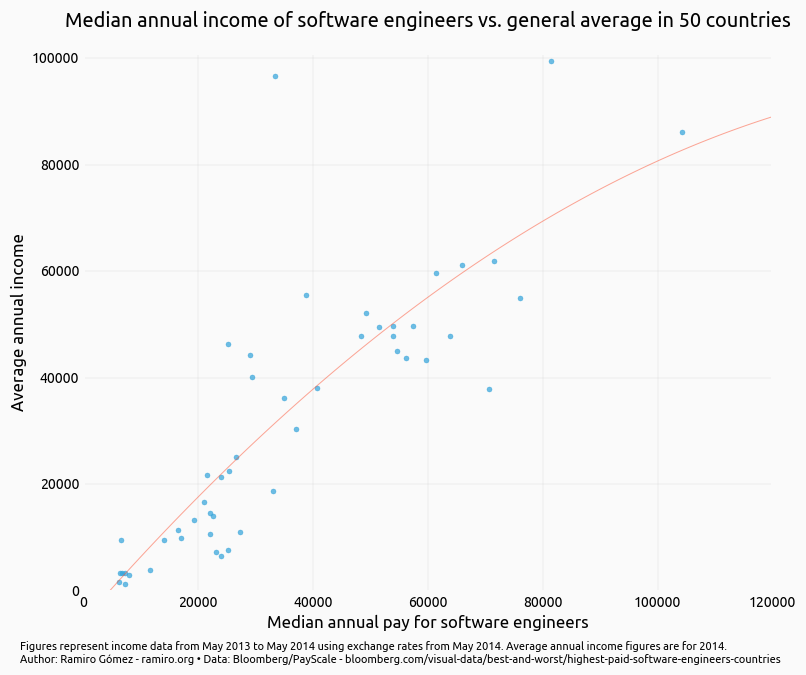

In [314]:
x = 'Median annual pay for software engineers'
y = 'Average annual income'
title = 'Median annual income of software engineers vs. general average in 50 countries'

fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(111)
ax.plot(x, y, '.', data=df, ms=10, alpha=.7)
ax.set_title(title, fontsize=20, y=1.04)
ax.set_xlabel(x)
ax.set_ylim(bottom=0, top=101000)
ax.set_ylabel(y)

# Polynomial curve fitting 
# http://docs.scipy.org/doc/numpy/reference/routines.polynomials.classes.html
polynomial = np.polynomial.Polynomial.fit(df[x], df[y], 2)
xp = np.linspace(0, 120000, 100)
yp = polynomial(xp)
ax.plot(xp, yp, '-', lw=1, alpha=.5)

fig.text(0, -.04 , chartinfo, fontsize=11)
plt.show()

Before interpreting this and the following plots, I'll point out a few issues with the data. We do not know how many respondents took part in the PayScale survey and we do know that their work experiences range from 2 to 5 years. Whether this sample is a good representation for the income of Software Engineers in the respective countries is questionable.

Moreover, we compare median annual values for Software Engineers with mean annual values for the general population. Considering [how large the income share of top earners](http://ramiro.org/notebook/top-incomes-share/) is in several countries, annual median values for the general population might well show a different picture.

With this in mind, Software Engineer looks like a good career choice in the majority of the 50 countries. In some of the countries we see in the lower left, mid-level Software Engineers earn multiples of what the average person does. But there are also countries, where Software Engineers earn a lot less. To find out which are the best and worst countries for Software Engineers with respect to income we'll plot rankings in form of bar plots next.

Map country names to ISO3 codes and delete columns not needed in the [Web based map](http://maps.ramiro.org/income-software-engineers-countries/).

In [178]:
names = gc.get_countries_by_names()
df['iso3'] = df['Country'].apply(lambda x: names[x]['iso3'])
df.head(5)

,Country,Ratio of median software engineer pay to average income,Median annual pay for software engineers,Average annual income,iso3
Rank,,,,,
1,Pakistan,5.56,7200,1296,PAK
2,India,3.91,6200,1584,IND
3,South Africa,3.64,24000,6595,ZAF
4,Bulgaria,3.28,25200,7682,BGR
5,China,3.15,23100,7333,CHN


Save as CSV.

In [179]:
df.to_csv(data_dir + '/economy/income-software-engineers-countries.csv', encoding='utf-8', index=False)

In [262]:
signature